# Notebook Purpose

Test if we can network model outputs to Unity.

# Import Dependencies

Dependencies will also compile special loss functions (CUDA implemented Earth Mover's Distance) which is in the `emd/structured_losses` directory.

In [ ]:
import numpy as np
from pointcloud_helpers import *

import keras
from keras.losses import MSE
from keras.layers import Lambda, Input, Dense, Conv1D, Conv2D, MaxPooling1D, BatchNormalization, MaxPooling2D, Flatten, Reshape, UpSampling2D, Dropout
from keras.models import Model, Sequential,load_model
from keras import callbacks
from keras import backend as K

config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

K.clear_session()

# Defining Model Architecture [Keras]

Float version of MSE Loss Function 

In [3]:
def mse(y_pred, y_true):
    return keras.backend.cast(MSE(y_pred, y_true), dtype='float32')

## Defining Shared Layers and Global Variables

- `bottleneck_size` number of dimensions on the latent / semantic space.
- `sem_param_shape` refers to the number of semantic dimensions we want to train on.

The shared layers consist of blocks of Conv2D + Relu + BatchNormalization. There are also Linear and Dropout layers involved for upsampling and reconstruction. 

In [4]:
bottleneck_size = 6
sem_param_shape = (bottleneck_size,)


en_conv_1 = Conv2D(64, kernel_size = 1, activation='relu')
bnorm_1 = BatchNormalization()
en_conv_2 = Conv2D(128, kernel_size = 1, activation='relu')
bnorm_2 = BatchNormalization()
# en_conv_3 = Conv2D(128, kernel_size = 1, activation='relu')
# bnorm_3 = BatchNormalization()
en_conv_4 = Conv2D(256, kernel_size = 1, activation='relu')
bnorm_4 = BatchNormalization()
en_conv_5 = Conv2D(bottleneck_size, kernel_size = 1, activation='relu')
bnorm_5 = BatchNormalization()
mpool_1 = MaxPooling2D(pool_size = (2048,1), name='encoder_out')

de_conv_1 = Conv2D(1024, kernel_size = 1, activation='relu')
de_conv_2 = Conv2D(2048, kernel_size =1, activation='relu')
dense_1 = Dense(2048 * 3, name='decoder_out')

de_drop_2 = Dropout(.5, input_shape=(1,6144))
de_drop_1 = Dropout(.1)



## Constructing the encoder and decoder

Architecture as per Pointnet and Achlioptas (2018) with tweaks of my own. I added dropout and took out a layer `en_conv_3`, `bnorm_3` to reduce the complexity of my model and work against overfitting. 

In [5]:
ptcloud_shape = (2048,1,3)

# build encoder model
ptcloud_input = Input(shape=ptcloud_shape, name="encoder_input")
x = en_conv_1(ptcloud_input)
x = bnorm_1(x)
x = en_conv_2(x)
x = bnorm_2(x)
# x = en_conv_3(x)
# x = bnorm_3(x)
x = en_conv_4(x)
x = bnorm_4(x)
x = en_conv_5(x)
x = bnorm_5(x)
encoder_out = mpool_1(x)

# instantiate encoder model
encoder = Model(ptcloud_input, encoder_out, name='encoder')

# build decoder model
latent_inputs = Input(shape=(1,1,bottleneck_size), name='decoder_input')
x = de_conv_1(latent_inputs)
x = de_drop_1(x)
x = de_conv_2(x)
x = de_drop_2(x)
decoder_out = dense_1(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs=decoder_out, name='decoder')


## Creating data path for first synthetic data input

This is the first data path for the first item in the three-element tuple, a synthetic input. <br> 

Here we assign a losses and loss weights for a multi-output model. This model takes in one pointcloud (of synthetic data) and outputs the semantic space embedding (encoder output) as well as the reconstructed pointcloud (decoder output).

In [6]:
synthetic_input1 = Input(shape=ptcloud_shape)

encoder_out = encoder(synthetic_input1)
decoder_out = decoder(encoder_out)

synthetic_base_ae = Model(synthetic_input1, outputs=[encoder_out, decoder_out], name='synthetic_base_ae')

losses ={'encoder':mse,
         'decoder': emd}
loss_weight_vars={'encoder':0.03,
          'decoder': 4}


synthetic_base_ae.compile(optimizer='adam', loss=losses, loss_weights=loss_weight_vars)
synthetic_base_ae.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2048, 1, 3)        0         
_________________________________________________________________
encoder (Model)              (None, 1, 1, 6)           44958     
_________________________________________________________________
decoder (Model)              (None, 1, 1, 6144)        14695424  
Total params: 14,740,382
Trainable params: 14,739,474
Non-trainable params: 908
_________________________________________________________________


This is the second data path for the second item in the three-element tuple, a synthetic input that differs from the first input on only one semantic dimension. <br> 

It is the same as the first in every respect.

In [7]:
synthetic_input2 = Input(shape=ptcloud_shape)

encoder_out = encoder(synthetic_input2)
decoder_out = decoder(encoder_out)

synthetic_edit_ae = Model(synthetic_input2, outputs=[encoder_out, decoder_out], name='synthetic_edit_ae')


synthetic_edit_ae.compile(optimizer='adam', loss=losses, loss_weights=loss_weight_vars)
synthetic_edit_ae.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2048, 1, 3)        0         
_________________________________________________________________
encoder (Model)              (None, 1, 1, 6)           44958     
_________________________________________________________________
decoder (Model)              (None, 1, 1, 6144)        14695424  
Total params: 14,740,382
Trainable params: 14,739,474
Non-trainable params: 908
_________________________________________________________________


This is the third data path for the third item in the three-element tuple, a real input. <br> 

It differs in that it only uses only reconstruction loss to optimze the encoder and decoder.

In [8]:
real_input = Input(shape=ptcloud_shape)
encoder_out = encoder(real_input)
decoder_out = decoder(encoder_out)

real_ae = Model(real_input, outputs=decoder_out, name='real_ae')
real_ae.compile(optimizer='adam', loss=emd)
real_ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2048, 1, 3)        0         
_________________________________________________________________
encoder (Model)              (None, 1, 1, 6)           44958     
_________________________________________________________________
decoder (Model)              (None, 1, 1, 6144)        14695424  
Total params: 14,740,382
Trainable params: 14,739,474
Non-trainable params: 908
_________________________________________________________________


## Compile different paths through encoder and decoder into one meta-model

Run placeholder inputs through the model to establish data paths.

In [9]:
synth_base_en, synth_base_de = synthetic_base_ae(synthetic_input1)
synth_edit_en, synth_edit_de = synthetic_edit_ae(synthetic_input2)
real_de = real_ae(real_input)

Add callbacks to monitor training.

In [10]:
earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=0, mode='min')
mcp_save = callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='loss', mode='min')


Compile with hyperparameter losses and an optimizer.

In [11]:
semantic_net = Model(inputs=[synthetic_input1, synthetic_input2, real_input], outputs=[synth_base_en, synth_base_de, synth_edit_en, synth_edit_de, real_de], name="semantic_net")

losses =[mse, emd, mse, emd, emd]
loss_weight_vars=[0.1,4,0.1,4,1]


opt = keras.optimizers.Adam(lr=0.00001, clipvalue=0.5)
semantic_net.compile(optimizer=opt,loss=losses, loss_weights= loss_weight_vars)


# Import saved weights

In [12]:
with open('../model_exports_weights/semantic_net_decoder_weights.pkl', 'rb') as f:
    decoder_weights = pickle.load(f)

In [13]:
decoder.set_weights(decoder_weights)

# Check model outputs qualitatively

Note that there are 6 dimensions that can be altered. They map to the semantic parameters in this order:  torso_length, neck_length, neck_rotation, leg_length, tail_length, tail_rotation. As all parameters were normalized prior to training, any value between 0-1 is valid.

In [14]:
X_test = np.zeros((1,1,1,6))
X_test[0,0,:] = np.array([0.2,0.3,0.3,0.4,0.5,0.5])
predicted = semantic_net.layers[-1].layers[-1].predict(X_test).reshape(2048,3)

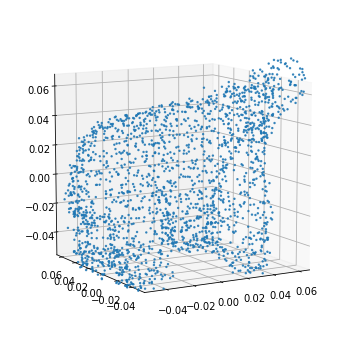

In [15]:
plot_ptcloud(predicted)

In [16]:
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from flask import Flask, send_file, request, jsonify, g
from werkzeug.exceptions import BadRequest
from werkzeug.utils import secure_filename

app = Flask(__name__)
#handles web requests from unity
@app.route('/', methods=["POST"])
def evaluate():
    values = request.form["values"].split('|')
    
    #split the 6 values into something
    values = np.array([float(val) for val in values])
    random_decoded = decoder.predict(values.reshape(1,1,1,6)).reshape(2048,3)

    #return 12 nearest neighbors
    return jsonify(random_decoded.tolist())

def run():
    app.run(host='0.0.0.0',port=5000, threaded=False)


In [17]:
run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


In [17]:
#get all data and encode their embedding
# in some tsne with randomness set to a seed


NameError: name 'values' is not defined

# Load Data

In [18]:

synthetic_pairs = np.load('../data/norm_synthetic_ptclouds.npz')['array1']
synthetic_params = np.load('../data/norm_synthetic_params.npz')['array1']
real_ptclouds = np.load('../data/norm_real_ptclouds.npz')['array1']

In [19]:
real_ptclouds = real_ptclouds.repeat((int(synthetic_pairs.shape[1]/real_ptclouds.shape[0])),axis=0)
real_ptclouds = np.expand_dims(real_ptclouds,0)
synthetic_pairs = synthetic_pairs[:,:real_ptclouds.shape[1],:,:]
ptcloud_trios = np.vstack([synthetic_pairs,real_ptclouds])

synthetic_params = np.expand_dims(np.expand_dims(synthetic_params,2),2)

train_ptclouds = np.expand_dims(ptcloud_trios,3)
train_params = synthetic_params[:,:train_ptclouds.shape[1],:,:,:]

In [20]:
train_ptclouds = train_ptclouds.reshape(3*9996,2048,1,3)

In [49]:
# encoded_training_data = encoder.predict(train_ptclouds)

In [25]:
with open("encoded_training_data.pkl", "rb") as f:
    encoded_training_data = pickle.load(f)

# TSNE

TSNE from 6 dimensions to 3 dimensions.

In [52]:

from sklearn.manifold import TSNE

In [54]:
encoded_training_data.shape

(29988, 1, 1, 6)

In [68]:
encoded_training_data[:,0,0,0].shape

(29988,)

In [73]:

import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')

zline = encoded_training_data[::100,0,0,0]
xline = encoded_training_data[::100,0,0,1]
yline = encoded_training_data[::100,0,0,2]
ax.scatter(xline, yline, zline, 'gray')
plt.show()

In [27]:
X = encoded_training_data[:,0,0,:]

In [28]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import random
random.seed(1)
nbrs = NearestNeighbors(n_neighbors=12, algorithm='kd_tree').fit(X)



In [29]:
#whatever value you get return
distances, indices = nbrs.kneighbors(np.array([[0,0,0,0,0,0]]))


In [30]:
decoder.predict(X[indices].reshape(12,1,1,6)).shape

(12, 1, 1, 6144)

In [86]:
app = Flask(__name__)
#handles web requests from unity
@app.route('/', methods=["POST"])
def evaluate():
    values = request.form["values"].split('|')
    
    #split the 6 values into something
    values = np.array([[float(val) for val in values]])
    
    distances, indices = nbrs.kneighbors(values)
    
    closest_ptclouds = decoder.predict(X[indices].reshape(12,1,1,6))
    
    pointcloud_neighborhood = closest_ptclouds.reshape(12*6144)
    
#     pointcloud_output = {}

    xyz_string = ",".join([str(pt) for pt in pointcloud_neighborhood.tolist()])
    pointcloud_output = xyz_string

    
    #return 12 nearest neighbors
    return jsonify(pointcloud_output)

In [87]:
run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
172.17.0.1 - - [23/Feb/2021 06:23:18] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [23/Feb/2021 06:23:18] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [23/Feb/2021 06:23:19] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [23/Feb/2021 06:23:19] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [23/Feb/2021 06:23:19] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [23/Feb/2021 06:23:19] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [23/Feb/2021 06:23:19] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [23/Feb/2021 06:23:21] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [23/Feb/2021 06:23:21] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [23/Feb/2021 06:23:21] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [23/Feb/2021 06:23:21] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [23/Feb/2021 06:23:21] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [23/Feb/2021 06:23:22] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [23/Feb/2021 06:23:23] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [23/Feb/2021 06:23:23] "POST / HTTP/1.1" 200 -
172.17.0.1 -

In [44]:
np.zeros((12,2048,3)).reshape((12,6144)).tolist().join(',')

AttributeError: 'list' object has no attribute 'join'

In [76]:
pointcloud_neighborhood = np.zeros((12,6144))

In [78]:
xyz_string = ",".join([str(pt) for pt in pointcloud_neighborhood.tolist()])

In [79]:
xyz_string


'[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0